In [1]:
import os
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import random_split, Subset

sys.path.append('../src/spectrogram')

from autoencoder_vit import DinoV2Autoencoder
from autoencoders import ResNetAutoEncoder
from data_loader import SpectogramDataset, ConstilationDataset

In [2]:
# --- Configuration ---
# Adjust these paths to point to your dataset
BASE_DATA_PATH = '../data/own/unlabeled_10k/train/' # Example path
CLASSES = ['OOK', '4ASK', '8ASK', 'OQPSK', 'CPFSK', 'GFSK', '4PAM', 'DQPSK', '16PAM', 'GMSK']

# Hyperparameters
NUM_EPOCHS = 20
LEARNING_RATE = 1e-4
BATCH_SIZE = 32
NUM_WORKERS = 4 # Adjust based on your system
EVAL_STEP = 5   # Evaluate on validation set every 5 epochs

# Define the transformation to apply to the spectrogram images
# The models expect a certain input size, e.g., 224x224 for ViT.
TRANSFORM = transforms.Compose([
    transforms.Resize((96, 96)), # Resizing to 96x96 as seen in your decoder architectures
    transforms.ToTensor()
])

In [3]:
class DatasetFactory:
    """A callable class that creates SpectogramDataset instances for different modes."""
    def __init__(self, dataset_path, classes, transform):
        self.dataset_path = dataset_path
        self.classes = classes
        self.transform = transform

        # Create the full dataset
        full_dataset = ConstilationDataset(
            dataset_path=self.dataset_path,
            classes=self.classes,
            transform=self.transform
        )

        # Split the dataset into train, validation, and test sets
        dataset_size = len(full_dataset)
        val_size = int(0.1 * dataset_size)
        test_size = int(0.1 * dataset_size)
        train_size = dataset_size - val_size - test_size

        # Ensure reproducibility with a fixed generator
        generator = torch.Generator().manual_seed(42)
        self.train_dataset, self.val_dataset, self.test_dataset = random_split(
            full_dataset, [train_size, val_size, test_size], generator=generator
        )

    def __call__(self, mode='train'):
        """
        Args:
            mode (str): 'train', 'val', or 'test'.
        Returns:
            torch.utils.data.Subset: A subset of the dataset for the specified mode.
        """
        if mode == 'train':
            print(f"Using {len(self.train_dataset)} samples for training.")
            return self.train_dataset
        elif mode == 'val':
            print(f"Using {len(self.val_dataset)} samples for validation.")
            return self.val_dataset
        elif mode == 'test':
            print(f"Using {len(self.test_dataset)} samples for testing.")
            return self.test_dataset
        else:
            raise ValueError(f"Mode '{mode}' not recognized. Use 'train', 'val', or 'test'.")


# Create the dataset factory instance
dataset_factory = DatasetFactory(BASE_DATA_PATH, CLASSES, TRANSFORM)

--- Training DinoV2Autoencoder ---


Using cache found in /home/woreom/.cache/torch/hub/facebookresearch_dino_main


Using 16000 samples for training.
Using 2000 samples for validation.
Using 2000 samples for testing.


Epoch 5:   0%|          | 0/500 [00:46<?, ?batch/s]


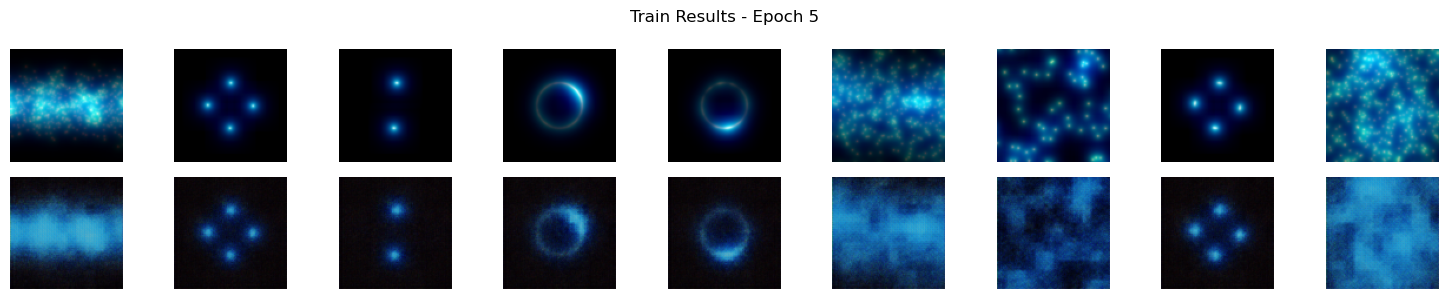

Epoch 5:   0%|          | 0/63 [00:02<?, ?batch/s]


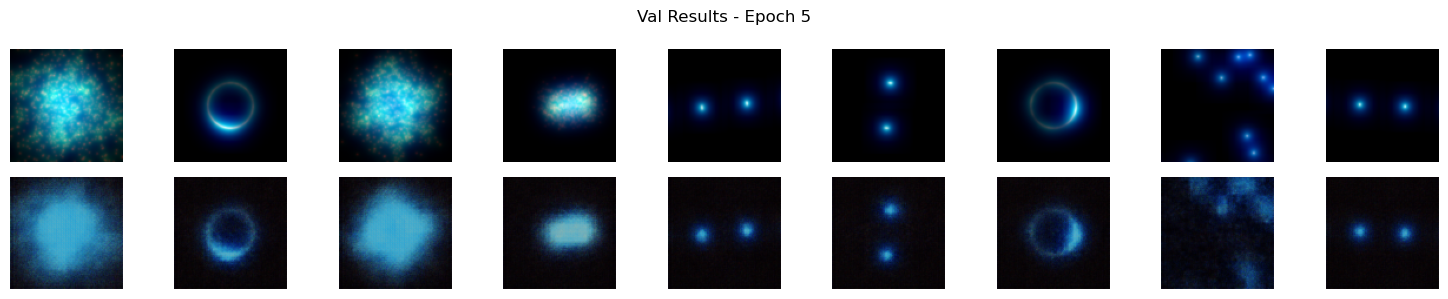

Epoch 10:   0%|          | 0/500 [00:47<?, ?batch/s]


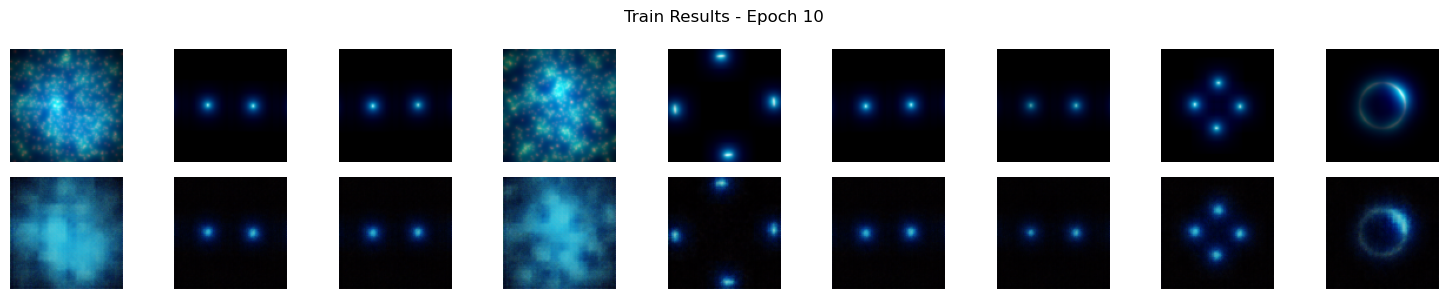

Epoch 10:   0%|          | 0/63 [00:02<?, ?batch/s]


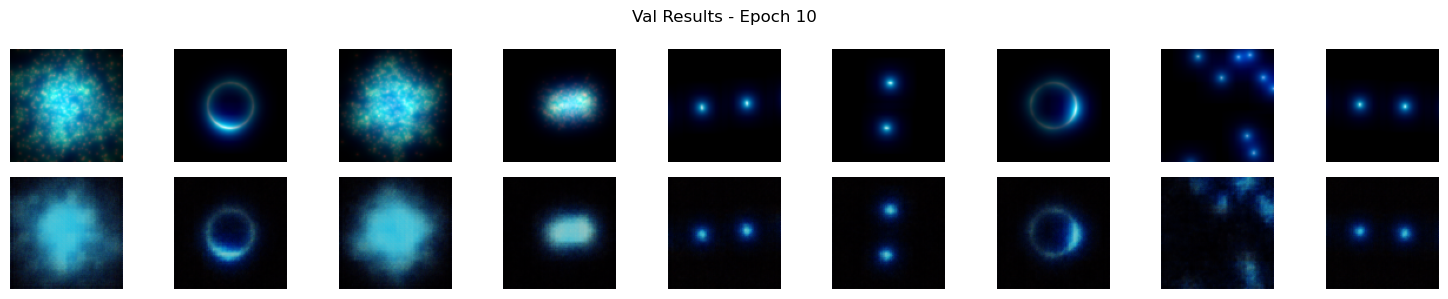

Epoch 15:   0%|          | 0/500 [00:47<?, ?batch/s]


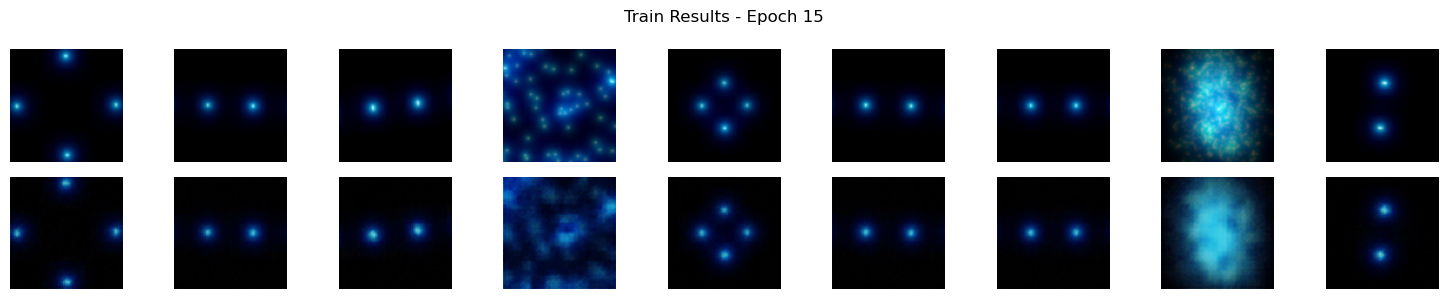

Epoch 15:   0%|          | 0/63 [00:02<?, ?batch/s]


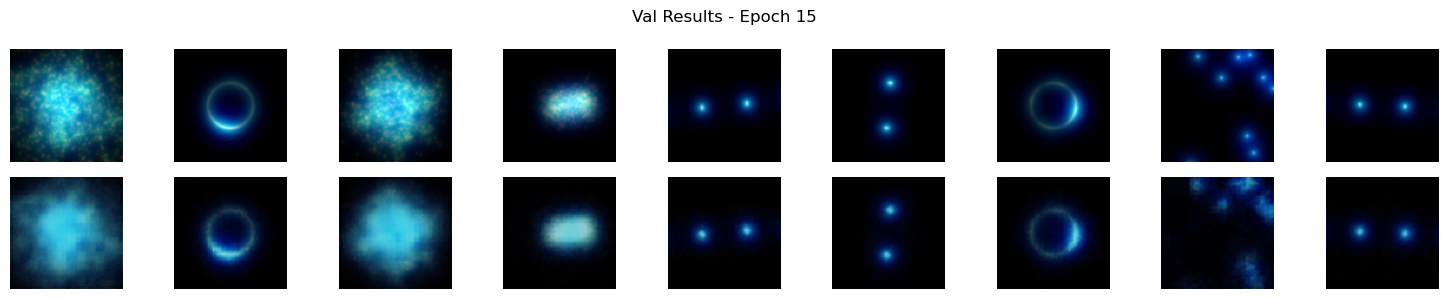

Epoch 20:   0%|          | 0/500 [00:47<?, ?batch/s]


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/woreom/.local/lib/python3.10/site-packages/IPython/core/formatters.py", line 282, in catch_format_error
    r = method(self, *args, **kwargs)
  File "/home/woreom/.local/lib/python3.10/site-packages/IPython/core/formatters.py", line 402, in __call__
    return printer(obj)
  File "/home/woreom/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py", line 170, in print_figure
    fig.canvas.print_figure(bytes_io, **kw)
  File "/home/woreom/miniconda3/envs/unsloth2/lib/python3.10/site-packages/matplotlib/backend_bases.py", line 2184, in print_figure
    result = print_method(
  File "/home/woreom/miniconda3/envs/unsloth2/lib/python3.10/site-packages/matplotlib/backend_bases.py", line 2040, in <lambda>
    print_method = functools.wraps(meth)(lambda *args, **kwargs: meth(
  File "/home/woreom/miniconda3/envs/unsloth2/lib/python3.10/site-packages/matplotlib/backends/backend_agg.py", line 481, in print_png
    self._print_pil(filename

<Figure size 1500x300 with 18 Axes>

Epoch 20:   0%|          | 0/63 [00:01<?, ?batch/s]


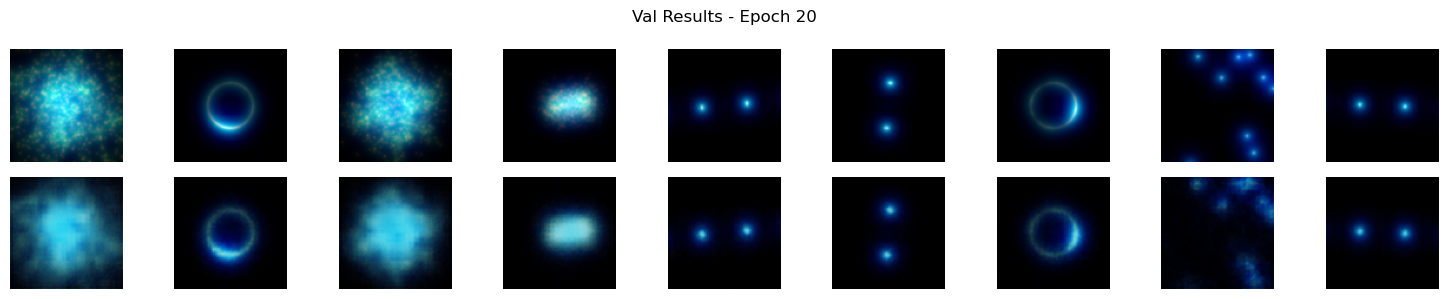

Epoch 20:   0%|          | 0/63 [00:02<?, ?batch/s]


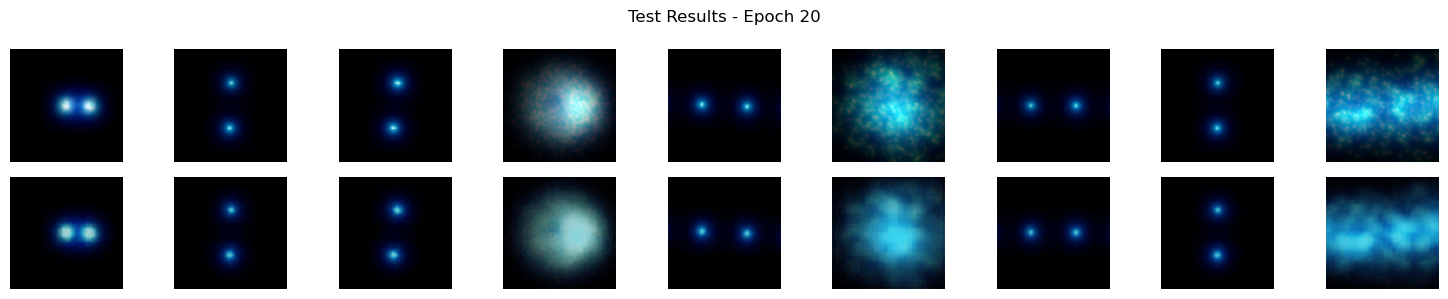

--- DinoV2Autoencoder Training Complete ---


In [4]:
print("--- Training DinoV2Autoencoder ---")

# 1. Initialize the model
dino_model = DinoV2Autoencoder(
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    eval_step=EVAL_STEP,
    freeze_encoder=False # Set to False to fine-tune the DINOv2 encoder
)

# 2. Start the training process
# The .fit() method handles the training loop, optimizer, and loss function internally.
dino_model.fit(
    dataset=dataset_factory,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE
)
torch.save(dino_model.state_dict(), '../exp/dino_autoencoder.pth')


print("--- DinoV2Autoencoder Training Complete ---")

In [5]:
torch.save(dino_model.state_dict(), '../exp/dino_autoencoder_test.pth')


--- Training ResNetAutoEncoder ---
Using 8000 samples for training.
Using 1000 samples for validation.
Using 1000 samples for testing.


Epoch 20: 100%|██████████| 32/32 [00:01<00:00, 29.49batch/s, loss=0.0075, mode=test] 


--- ResNetAutoEncoder Training Complete ---


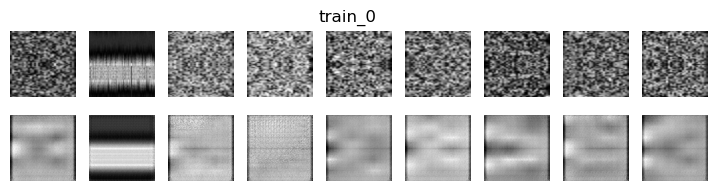

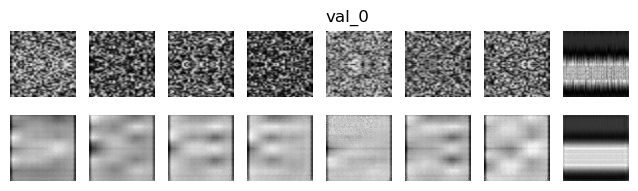

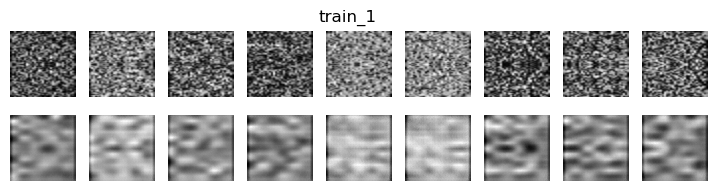

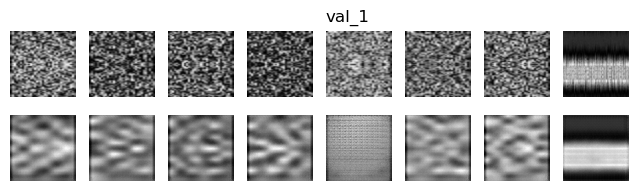

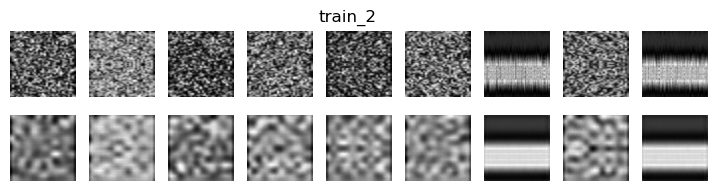

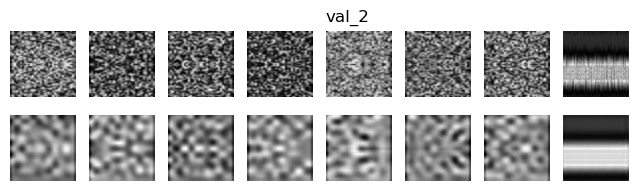

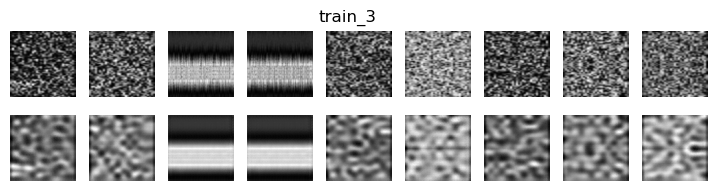

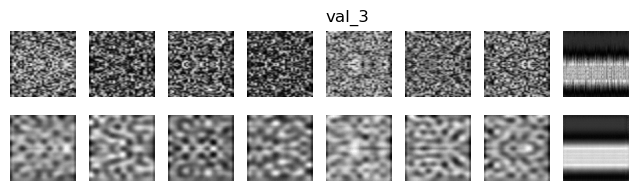

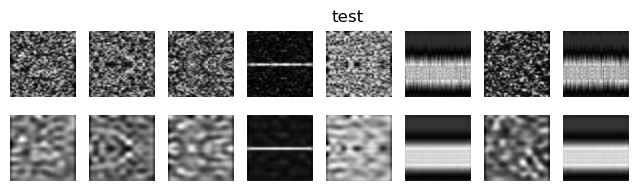

In [10]:
print("\n--- Training ResNetAutoEncoder ---")

# 1. Initialize the model
# Using 'resnet34' as an example architecture
resnet_model = ResNetAutoEncoder(
    arch='resnet34',
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    eval_step=EVAL_STEP
)

# 2. Define optimizer and loss for the ResNet model's fit method
optimizer = optim.AdamW(resnet_model.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()

# 3. Start the training process
resnet_model.fit(
    dataset=dataset_factory,
    optimizer=optimizer,
    loss=criterion,
    num_epochs=NUM_EPOCHS
)
torch.save(resnet_model.state_dict(), '../exp/resnet_autoencoder.pth')


print("--- ResNetAutoEncoder Training Complete ---")